In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.0.0+cu118'

# Estimate parameters in a linear regression model

1. Create synthetic data

In [ ]:
#### Estimate parameters in a linear regression model ####

# Create known parameters

weight = 0.7
bias = 0.3

# Create data

start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

# preview data
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

2. Create train-test split

In [ ]:
# Create train-test split of 80-20

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

3. Visualize the data

In [ ]:
# Visualize data

def plot_predictions(train_data=X_train,train_labels=y_train,test_data=X_test,test_labels=y_test,predictions=None):
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data,train_labels,c="blue",s=4,label="Training data")

  # Plot test data in green
  plt.scatter(test_data,test_labels,c="green",s=4,label="Test data")

  if predictions is not None:
    # Plot predictions on test set in red
    plt.scatter(test_data,predictions,c="red",s=4,label="Predicted labels")
  
  plt.legend(prop={"size": 14})

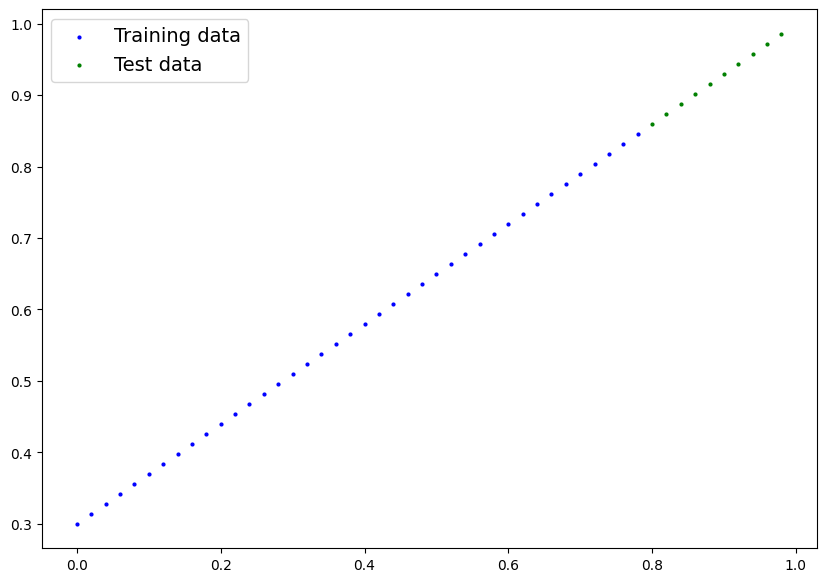

In [ ]:
plot_predictions()

4. Create a linear regression class using nn.Module

In [ ]:
# Create a Linear Regression class

class LinearRegressionModel(nn.Module):
  # nn.Module is a superclass that is used to customize a neural network
  # requires a forward() method to be defined

  def __init__(self):
    super().__init__()
    # nn.Parameter specifies tensors that define the layer
    # setting requires_grad=True means that parameter will be optimized
    # we start with random tensors of size 1 for both
    self.weights =  nn.Parameter(torch.randn(1,dtype=torch.float), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1,dtype=torch.float), requires_grad=True)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # a forward pass defines the computation done on the data at every iteration
    return self.weights * x + self.bias

5. Check the contents of the model

In [ ]:
### Check the contents of the model

torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()
# look at the nn.Parameters within the model
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# Check the state of the model with named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

6. Make predictions with untrained model

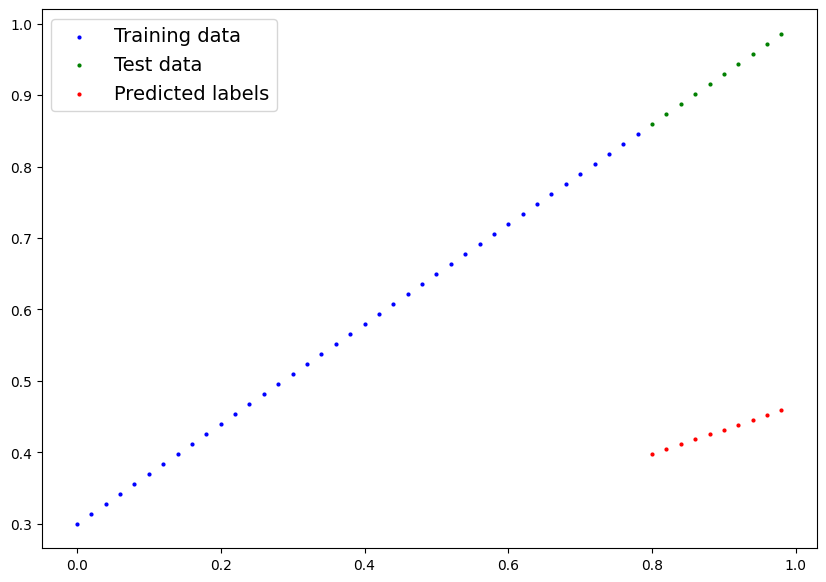

In [ ]:
### Making predictions with the model

with torch.inference_mode():
  # used when we are making inference with the model (not training)
  # does not do gradient tracking
  # just goes to forward pass
  # torch.no_grad() can also be used but inference_mode is faster
  y_preds = model_0(X_test)

# Check predictions
plot_predictions(predictions=y_preds)

In [ ]:
# Look at inference error

y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

7. Create a loss function and optimizer

In [ ]:
#### Create a loss function and optimizer ####

# L1 Loss is also called Mean Absolute Error (MAE). It sums up all the errors and takes the mean.
# Binary Cross Entropy (BCELoss) is used for binary classification problems.
loss_fn = nn.L1Loss()

# Stochastic gradient descent and Adam optimizer are commonly used.
# Inputs include model parameters and learning rate.
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)

# 8. Create a training-testing loop

Steps in a training loop:
1. Forward pass to calculate predicted values based on training data.
2. Calculate the loss based on training labels.
3. Set the optimizer gradients to 0 to be recalculated.
4. Perform backpropagation to calculate gradient of the loss for every parameter.
5. Update the optimizer with new gradients.

Steps in a testing loop:
1. Forward pass to calculate predicted values based on testing data.
2. Calculate the loss based on testing labels.
3. Calculate evaluation metrics like accuracy.


In [ ]:
#### Create a training-testing loop ####

epochs = 100

# Track loss values
train_loss_vals = []
test_loss_vals = []
epoch_count = []

for epoch in range(epochs):
  '''
  Perform training
  '''

  # Put model in training mode
  model_0.train()

  # Step 1: forward pass
  y_pred = model_0(X_train)

  # Step 2: Calculate loss
  loss = loss_fn(y_pred, y_train)

  # Step 3: Set optimizer gradients to zero
  optimizer.zero_grad()

  # Step 4: Backpropagation
  loss.backward()

  # Step 5: Update optimizer gradients
  optimizer.step()

  '''
  Perform testing
  '''

  # Put model in evaluation mode
  model_0.eval()

  with torch.inference_mode():
    # Step 1: Forward pass
    test_pred = model_0(X_test)

    # Step 2: Calculate loss
    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    # Step 3: Store metrics for evaluation
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_vals.append(loss.detach().numpy())
      test_loss_vals.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819


9. Plot the loss over epochs

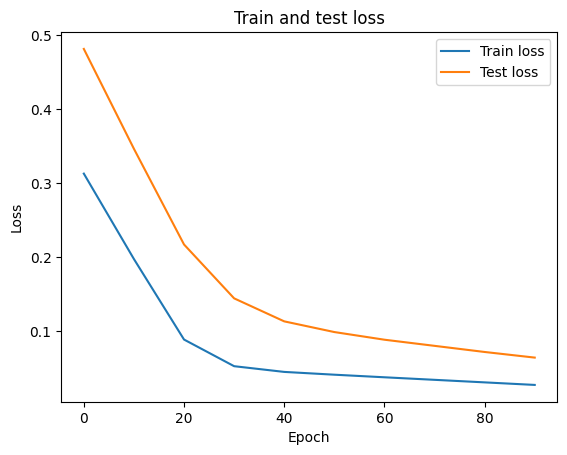

In [ ]:
# Plot the loss curves

plt.plot(epoch_count, train_loss_vals, label="Train loss")
plt.plot(epoch_count, test_loss_vals, label="Test loss")
plt.title("Train and test loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

In [ ]:
# Look at learned model parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [ ]:
# Original parameters
weight, bias

(0.7, 0.3)

10. Evaluate the model's performance

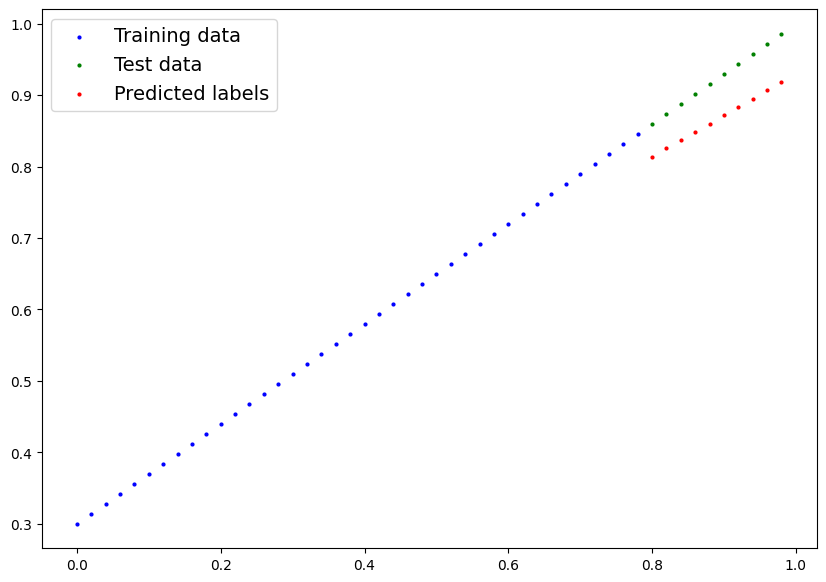

In [ ]:
#### Evaluate the model ####

# set model in evaluation mode
model_0.eval()

# set up inference mode context manager
with torch.inference_mode():
  # Make sure model and data are on correct device
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

# 11. Saving and loading the model

In [ ]:
#### Saving and loading models ####

'''
torch.save saves models, tensors or other Python objects to pickle.
torch.load unpickles a saved pickle file to load an object. device can also be set.
torch.nn.Module.load_state_dict will load the model's state_dict dictionary 
'''

from pathlib import Path

# Step 1: create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# Step 2: create a save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Step 3: save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),f=MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow_model_0.pth


In [ ]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1207 May 11 08:22 models/01_pytorch_workflow_model_0.pth


In [ ]:
# To retrieve the model parameters, we first load the saved state_dict
# and then load this into torch.nn.Module to a new instance of the model

# Create a new instance of the model
loaded_model_0 = LinearRegressionModel()

# Load state_dict
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
# Perform inference with loaded model

loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

Making the code device-agnostic

In [ ]:
#### Making the code agnostic to device ####

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


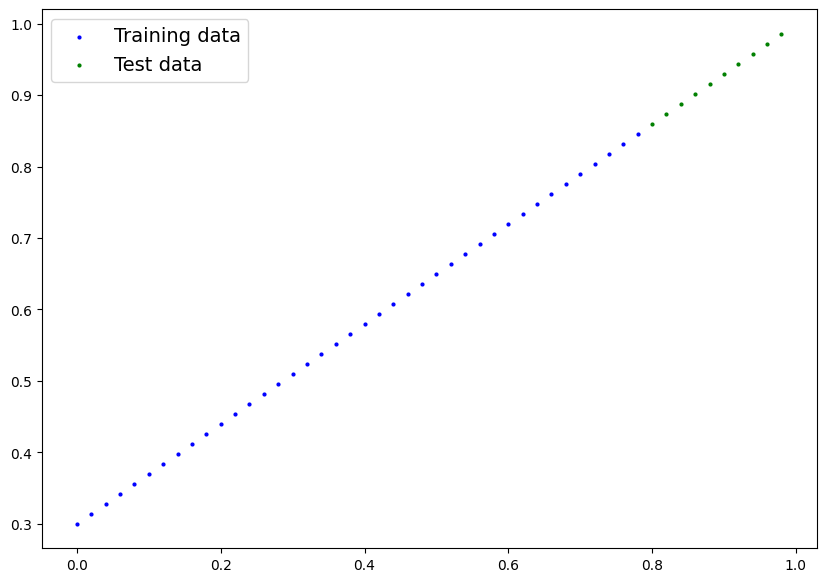

In [ ]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 

# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

plot_predictions(X_train, y_train, X_test, y_test)


In [ ]:
# Build a linear model

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # there is one input feature per label
    self.linear_layer = nn.Linear(in_features=1,out_features=1)

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
# Linear layer automatically holds weight and bias as parameters
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check model's current device (default is cpu)
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set model to GPU
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Build a train and test loop

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.01)

torch.manual_seed(42)

epochs = 1000

# Put data on device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Store loss
train_loss_vals = []
test_loss_vals = []
epoch_count = []

for epoch in range(epochs):
  # train the model

  model_1.train()
  y_pred = model_1(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # test the model
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred,y_test)

  if epoch % 100 == 0:
    epoch_count.append(epoch)
    train_loss_vals.append(loss.detach().cpu().numpy())
    test_loss_vals.append(test_loss.detach().cpu().numpy())
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5436570048332214 | Test loss: 0.560505211353302
Epoch: 100 | Train loss: 0.005878167692571878 | Test loss: 0.012984705157577991
Epoch: 200 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 300 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 400 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 500 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 600 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 700 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 800 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 900 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523


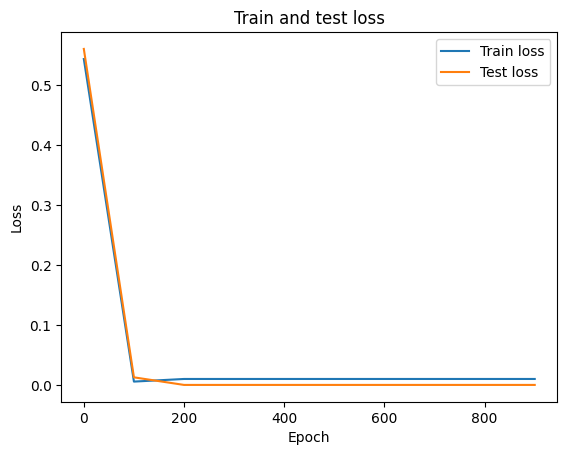

In [ ]:
# Plot the loss curves

plt.plot(epoch_count, train_loss_vals, label="Train loss")
plt.plot(epoch_count, test_loss_vals, label="Test loss")
plt.title("Train and test loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

In [ ]:
# Print out learned parameters

from pprint import pprint
pprint(model_1.state_dict())

OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2925], device='cuda:0'))])


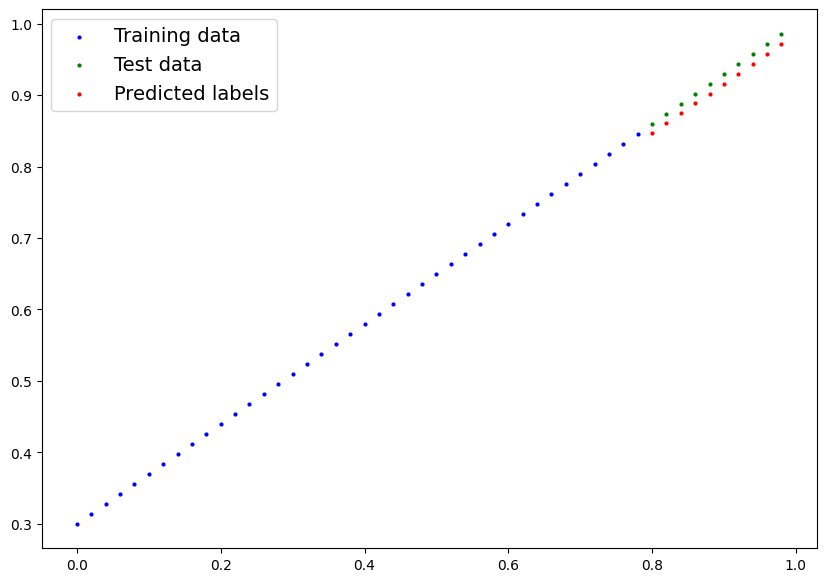

In [ ]:
# Make predictions

model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)

plot_predictions(predictions=y_preds.cpu())

# Exercises

In [ ]:
#### Exercises ####

# Qn 1: Create a straight line dataset

import torch
from torch import nn
import matplotlib.pyplot as plt

weight = 0.3
bias = 0.9

X = torch.arange(0,1,0.01)
y = weight * X + bias

len(X), len(y)

(100, 100)

In [ ]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [ ]:
def plot_predictions(train_data=X_train,train_labels=y_train,test_data=X_test,test_labels=y_test,predictions=None):
  # Plot training data
  plt.scatter(train_data,train_labels,c="blue",s=5,label="Training")
  
  # Plot testing data
  plt.scatter(test_data,test_labels,c="red",s=5,label="Testing")

  plt.xlabel("X")
  plt.ylabel("y")
  plt.title("Linear Model")
  
  if predictions is not None:
    plt.scatter(test_data,predictions,c="green",s=5, label="Predictions")
  plt.legend()

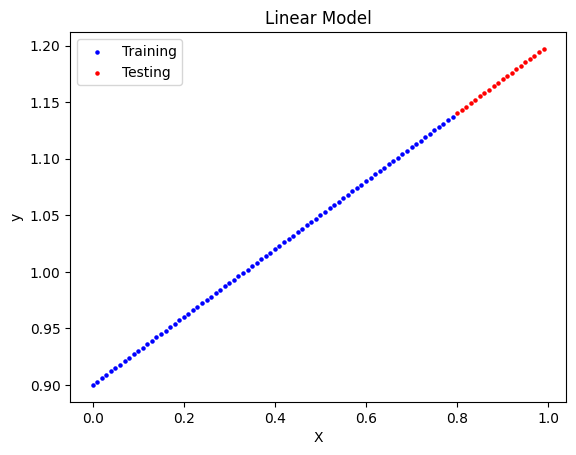

In [ ]:
plot_predictions()

In [ ]:
# Qn 2: Build a linear module

class LinearModel(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,dtype=float),requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1,dtype=float),requires_grad=True)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

In [ ]:
torch.manual_seed(42)

model_ex = LinearModel()
model_ex.state_dict()

OrderedDict([('weights', tensor([0.3367], dtype=torch.float64)),
             ('bias', tensor([0.1288], dtype=torch.float64))])

In [ ]:
# Qn 3: Create loss function and optimizer

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_ex.parameters(),lr=0.01)


In [ ]:
# write a train and test loop

device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 300
interval = 20

train_loss_vals = []
test_loss_vals = []

for epoch in range(epochs):
  # train the model
  model_ex.train()

  train_preds = model_ex(X_train.to(device))
  loss = loss_fn(train_preds, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % interval == 0:
    # test the model
    model_ex.eval()
    with torch.inference_mode():
      test_preds = model_ex(X_test.to(device))
      test_loss = loss_fn(test_preds,y_test)
      train_loss_vals.append(loss.detach().numpy())
      test_loss_vals.append(test_loss.detach().numpy())
      print(f"Epoch {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch 0 | Train loss: 0.7566978850205477 | Test loss: 0.7248174654184888
Epoch 20 | Train loss: 0.5254928853781197 | Test loss: 0.4541124656823234
Epoch 40 | Train loss: 0.29428788573569165 | Test loss: 0.18340746594615806
Epoch 60 | Train loss: 0.07658555325353075 | Test loss: 0.07274122116104585
Epoch 80 | Train loss: 0.052553712033635194 | Test loss: 0.11581578331597756
Epoch 100 | Train loss: 0.0455426820761507 | Test loss: 0.10467905803297743
Epoch 120 | Train loss: 0.03868856948548406 | Test loss: 0.08938330773272553
Epoch 140 | Train loss: 0.03183445689481727 | Test loss: 0.0740875574324729
Epoch 160 | Train loss: 0.024982301802456926 | Test loss: 0.05810385712437619
Epoch 180 | Train loss: 0.018130146710096596 | Test loss: 0.042120156816279494
Epoch 200 | Train loss: 0.011278970366889483 | Test loss: 0.0257924815042608
Epoch 220 | Train loss: 0.004429369271340572 | Test loss: 0.009467043690112609
Epoch 240 | Train loss: 0.0037011259984489216 | Test loss: 0.006490206455296588
Ep

Text(0, 0.5, 'Loss')

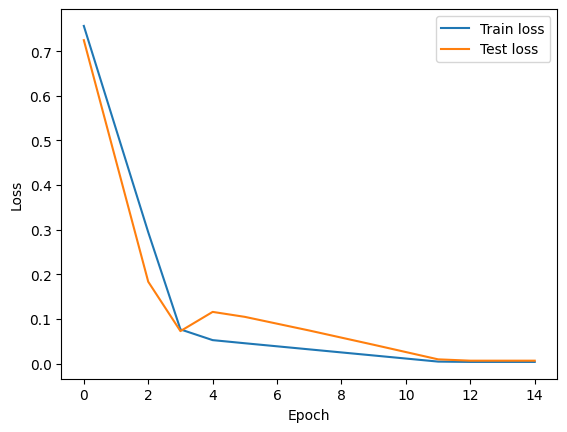

In [ ]:
# Plot the loss

plt.plot(train_loss_vals, label="Train loss")
plt.plot(test_loss_vals, label="Test loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

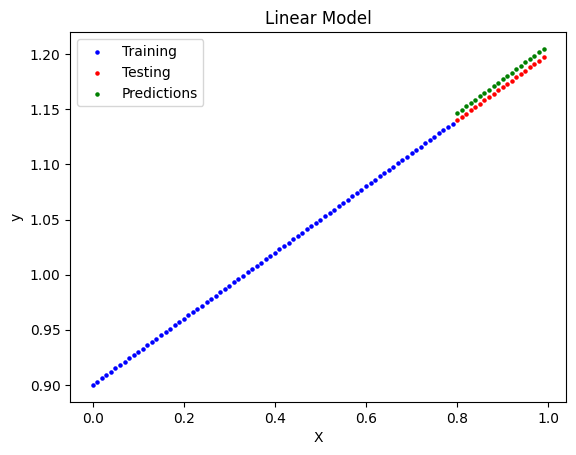

In [ ]:
# Qn 4: Make predictions on test data

model_ex.eval()
with torch.inference_mode():
  preds = model_ex(X_test.to(device))

plot_predictions(predictions=preds)

In [ ]:
# Qn 5: save model's state_dict

from pathlib import Path

# Step 1: create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# Step 2: create a save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Step 3: save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_ex.state_dict(),f=MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow_model_1.pth


In [ ]:
# load the state dict

model_ex_1 = LinearModel()
model_ex_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

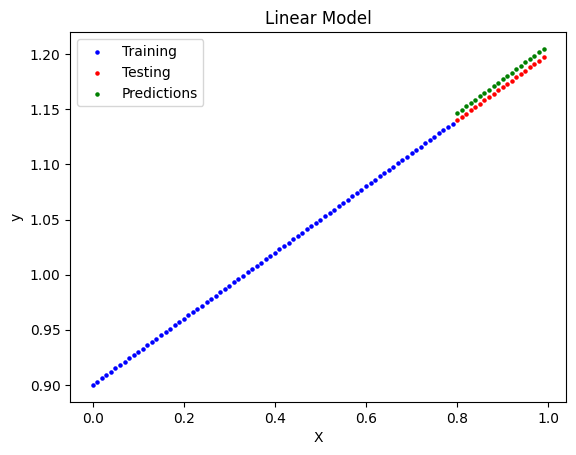

In [ ]:
model_ex_1.eval()
with torch.inference_mode():
  preds = model_ex_1(X_test.to(device))

plot_predictions(predictions=preds)